In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn import decomposition

from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import warnings

# Suppress warning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Read In Data

In [75]:
# Reading in the training data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# remove id columns from both
test_ids = test_df['PassengerId']

train_df = train_df.drop('PassengerId', axis=1)
test_df = test_df.drop('PassengerId', axis=1)

# print the train_df head
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [76]:
# Isolate target 'Transported'
target = train_df['Transported']
train_df.drop(columns = ['Transported'], inplace = True)

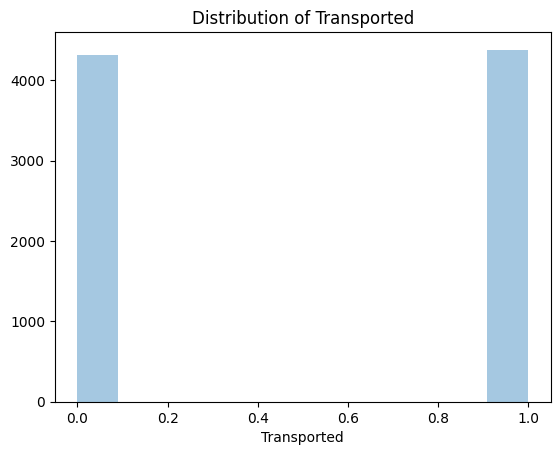

In [77]:
# plot hist
def plot_transported():
    fig, ax = plt.subplots()
    sns.distplot(target, ax=ax, kde=False)
    ax.set_title("Distribution of Transported")
    
# target
plot_transported()

In [78]:
# First, lets separate the data in the cabin column into it's respective pieces of data in the train df
cabin_split = train_df['Cabin'].str.split('/', expand=True)
cabin_split.columns = ['Deck', 'Room_Number', 'Side']
new_df = pd.concat([train_df, cabin_split], axis=1)
train_df = new_df
train_df.drop(columns=['Cabin'], inplace=True)

# First, lets separate the data in the cabin column into it's respective pieces of data in the test df
cabin_split = test_df['Cabin'].str.split('/', expand=True)
cabin_split.columns = ['Deck', 'Room_Number', 'Side']
new_df = pd.concat([test_df, cabin_split], axis=1)
test_df = new_df
test_df.drop(columns=['Cabin'], inplace=True)

train_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Room_Number,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S


# Eliminating Nans

In [79]:
# Initial missing values
train_df.isna().sum()

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Deck            199
Room_Number     199
Side            199
dtype: int64

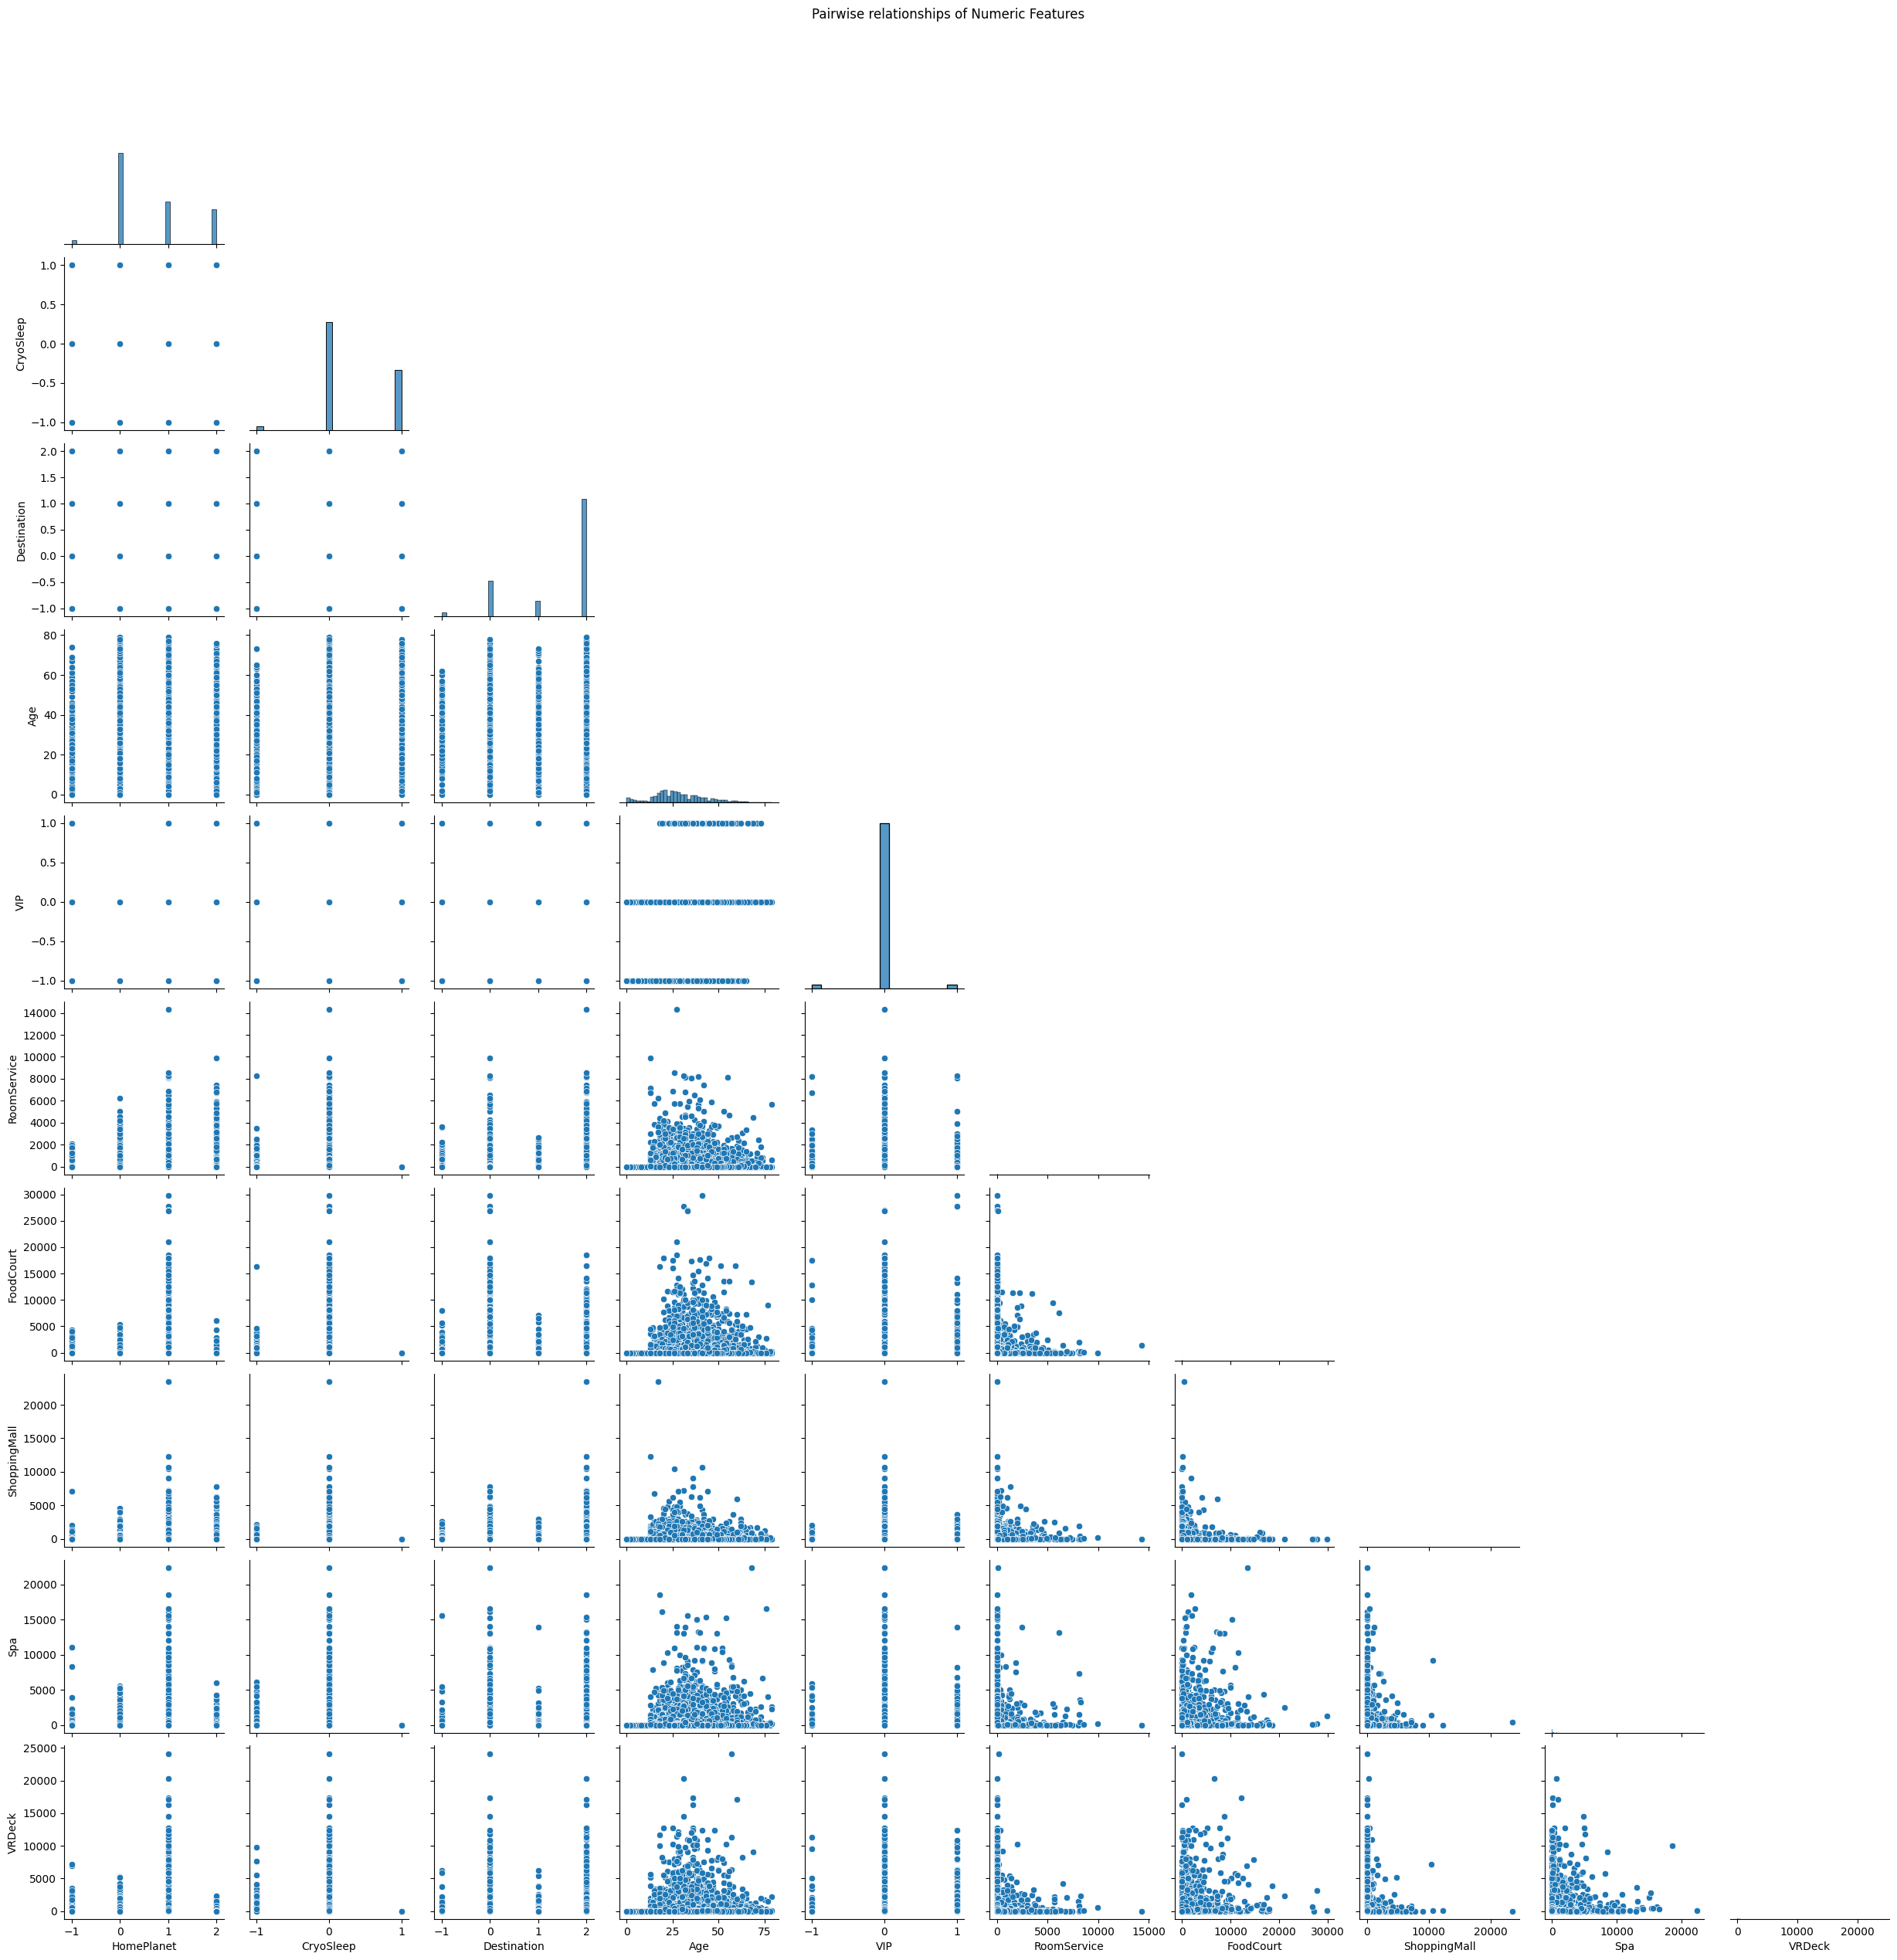

In [80]:
def plot_all_field_relationships(df):
    # Handle categorical data: Convert to numeric codes for correlation analysis (optional)
    # This step is simplistic and may not be meaningful for non-ordinal categories.
    df_numeric = df.copy()
    for col in df_numeric.select_dtypes(include=['object', 'bool']).columns:
        df_numeric[col] = df_numeric[col].astype('category').cat.codes

    # Pair Plot for numeric fields (considering the whole DataFrame may be too much, so focus on key fields)
    # Selecting a subset of fields if necessary due to the broad scope and to avoid overwhelming plots
    numeric_cols = df_numeric.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 10:  # limiting to first 10 numeric columns to keep the plot readable
        numeric_cols = numeric_cols[:10]
    sns.pairplot(df_numeric[numeric_cols], corner=True)
    plt.suptitle('Pairwise relationships of Numeric Features', y=1.02)
    plt.show()

plot_all_field_relationships(train_df)

In [100]:
# Cryo-sleep vs amount spent
def plot_spending_relationships_boolean(df):
    # Assuming 'CryoSleep' is a boolean or can be easily converted to one
    # Convert CryoSleep to a more understandable format for the plot
    df['CryoSleep'] = df['CryoSleep'].map({True: 'In CryoSleep', False: 'Not in CryoSleep'})
    
    # Define the spending categories
    spending_categories = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    
    # Melt the DataFrame to make it suitable for sns.catplot
    melted_df = df.melt(id_vars=['CryoSleep'], value_vars=spending_categories,
                        var_name='SpendingCategory', value_name='AmountSpent')
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.catplot(x='SpendingCategory', y='AmountSpent', hue='CryoSleep', kind='bar', data=melted_df)
    plt.title('Spending in Various Categories Based on CryoSleep Status')
    plt.xticks(rotation=45)
    plt.show()

AttributeError: 'NoneType' object has no attribute 'get_legend_handles_labels'

<Figure size 1000x600 with 0 Axes>

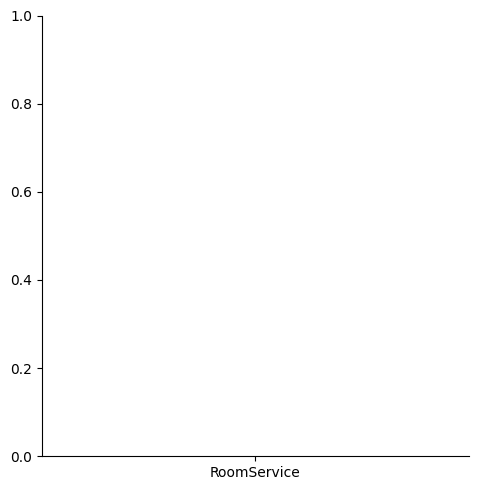

In [102]:
# cryo versus amount spent in all spenidng categories
plot_spending_relationships_boolean(train_df)

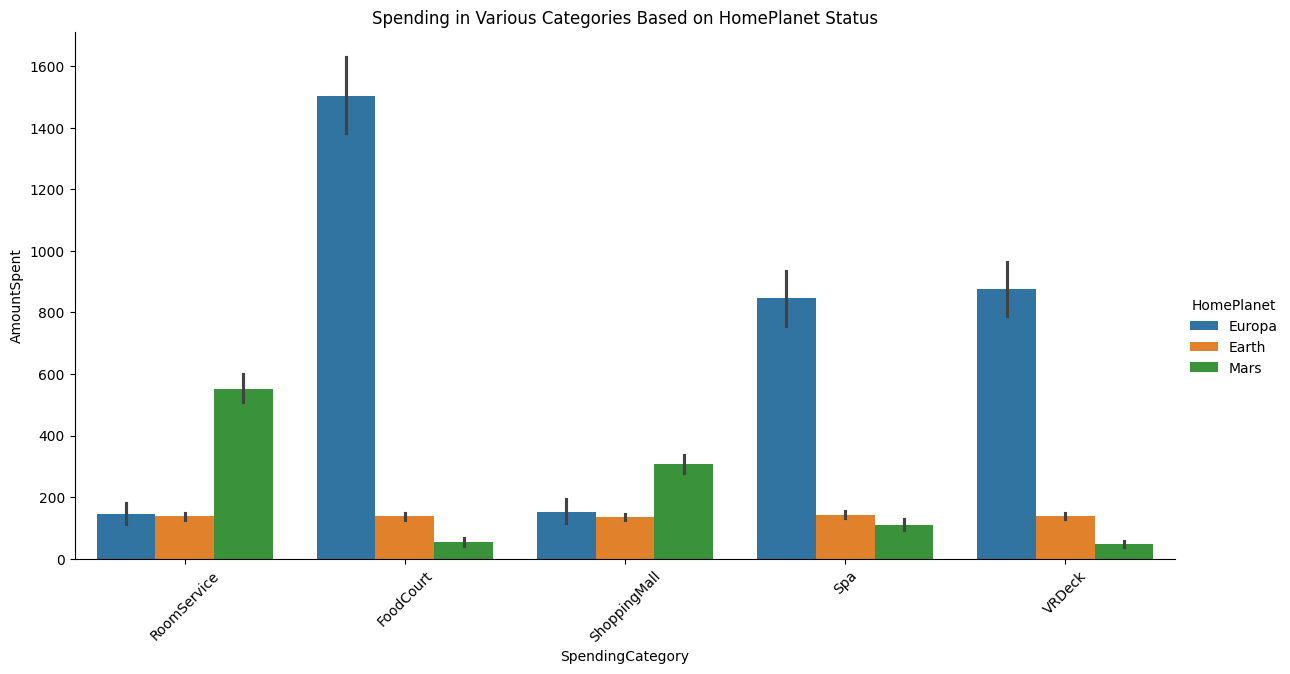

In [98]:
def plot_spending_relationships_categorical(df, category_column, spending_categories):
    # Melt the DataFrame to make it suitable for sns.catplot
    melted_df = df.melt(id_vars=[category_column], value_vars=spending_categories,
                        var_name='SpendingCategory', value_name='AmountSpent')
    
    # Plotting
    sns.catplot(x='SpendingCategory', y='AmountSpent', hue=category_column, kind='bar', data=melted_df, height=6, aspect=2)
    plt.title(f'Spending in Various Categories Based on {category_column} Status')
    plt.xticks(rotation=45)
    plt.show()

# Example usage:
plot_spending_relationships_categorical(train_df, 'HomePlanet', ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

## Investigation Co-linearities

In [83]:
group_means = train_df.groupby(['CryoSleep'])['ShoppingMall'].mean()
print(group_means)

CryoSleep
In CryoSleep          0.000000
Not in CryoSleep    270.586504
Name: ShoppingMall, dtype: float64
